In [1]:
from simulation_core import *
import simpy

## What do i want from this simulation?

- A plot of the distribution of the arrival times, for presentation reasons
- A plot showing the differences of the average waiting times between the number of the buses

In [2]:
BUS_CAPACITY = 25  # Amount of passengers that each bus can carry
TRAVEL_TIME = 15    # Time it takes for a bus to travel to its destination
MAX_PASSENGERS = 500  # Maximum number of passengers that can be generated in the simulation
BASE_LAMBDA = 1 # Regulates the average arrival rate of passengers (1/lambda is the average time between arrivals)
SIMULATION_TIME = 240
PEAK_HOUR = 150  # Time in minutes when the peak hour starts (e.g., 150 minutes = 2 hours and 30 minutes)
PEAK_FACTOR = 5 # Factor by which the arrival rate increases during the peak hour
SMART_PERCENTAGE = 0.5  # Percentage of bus capacity that must be filled before the bus departs
SMART_TIME = 10  # Time the bus can wait before deciding to leave
SMART_DRIVER = True # Indicates if the bus driver is smart (True) or not (False)
TOTAL_BUSES = 4 # Total number of buses in the simulation

smart_driver = [False]
bus_amount  = [3]
configurations = []

# Esegui la simulazione per diverse configurazioni di navette e smart driver
for TOTAL_BUSES in bus_amount :
    for SMART_DRIVER in smart_driver:
                # Crea una nuova configurazione per ogni combinazione di parametri
                configuration = Configuration(TOTAL_BUSES, SMART_DRIVER, SMART_TIME, SMART_PERCENTAGE, MAX_PASSENGERS)
                for i in range(10):  # Esegui 100 simulazioni per ogni configurazione

                    env = simpy.Environment()

                    # Questa è la coda dove i passeggeri si accodano appena arrivano
                    passenger_queue = simpy.Store(env) 

                    # Questo Store gestisce quale navetta è ATTIVA per l'imbarco in un dato momento
                    # Ha capacità 1, quindi solo UNA navetta può essere messa qui alla volta.
                    # Le navette "competono" per essere qui.
                    active_buses = simpy.Store(env, capacity=1)

                    # Avvia i processi delle navette
                    for i in range(TOTAL_BUSES):
                        navetta_obj = Bus(env, f'Bus_{i+1}', BUS_CAPACITY)
                        env.process(bus_process(env, navetta_obj, active_buses, passenger_queue,
                                                        SMART_DRIVER= SMART_DRIVER,
                                                            SMART_TIME=SMART_TIME,
                                                                SMART_PERCENTAGE=SMART_PERCENTAGE,
                                                                    TRAVEL_TIME=TRAVEL_TIME))

                    # Avvia il generatore di clienti
                    history = []  # Lista per tenere traccia dei clienti per il report finale
                    env.process(participant_generator(env, passenger_queue, history,
                                                    tempo_massimo_simulazione=SIMULATION_TIME,
                                                        MAX_PASSENGERS=MAX_PASSENGERS,
                                                            PEAK_HOUR=PEAK_HOUR,
                                                                BASE_LAMBDA=BASE_LAMBDA,
                                                                    PEAK_FACTOR=PEAK_FACTOR))

                    # Esegui la simulazione
                    print(f'--- Simulation started for {SIMULATION_TIME} minutes ---')
                    env.run(until=SIMULATION_TIME)
                    print('--- Simulation end ---')

                    configuration.history.append(history)  # Salva la storia dei passeggeri nella configurazione
                configurations.append(configuration)

--- Simulation started for 240 minutes ---

0.00: Bus_1 is at the stop and active for boarding.
3.02: Participant 1 arrives and joins general queue.
3.02: Bus_1: boarded passenger 1. Total: 1/25.
3.28: Participant 2 arrives and joins general queue.
3.28: Bus_1: boarded passenger 2. Total: 2/25.
3.53: Participant 3 arrives and joins general queue.
3.53: Bus_1: boarded passenger 3. Total: 3/25.
4.85: Participant 4 arrives and joins general queue.
4.85: Bus_1: boarded passenger 4. Total: 4/25.
6.88: Participant 5 arrives and joins general queue.
6.88: Bus_1: boarded passenger 5. Total: 5/25.
8.20: Participant 6 arrives and joins general queue.
8.20: Bus_1: boarded passenger 6. Total: 6/25.
8.79: Participant 7 arrives and joins general queue.
8.79: Bus_1: boarded passenger 7. Total: 7/25.
9.62: Participant 8 arrives and joins general queue.
9.62: Bus_1: boarded passenger 8. Total: 8/25.
9.93: Participant 9 arrives and joins general queue.
9.93: Bus_1: boarded passenger 9. Total: 9/25.
10.4

(array([ 2.,  4.,  7.,  2.,  3.,  4.,  4.,  3.,  7.,  4.,  4.,  6.,  4.,
         1.,  8.,  8.,  6.,  7.,  5.,  8., 12.,  3.,  9.,  4.,  9.,  9.,
         9.,  6., 14., 14., 12., 11., 11., 18., 11., 23., 13., 19., 11.,
        13., 16., 15., 16., 13., 23., 24., 21., 18., 13., 13.]),
 array([  1.94518038,   5.31977627,   8.69437217,  12.06896807,
         15.44356397,  18.81815987,  22.19275577,  25.56735167,
         28.94194757,  32.31654346,  35.69113936,  39.06573526,
         42.44033116,  45.81492706,  49.18952296,  52.56411886,
         55.93871476,  59.31331066,  62.68790655,  66.06250245,
         69.43709835,  72.81169425,  76.18629015,  79.56088605,
         82.93548195,  86.31007785,  89.68467374,  93.05926964,
         96.43386554,  99.80846144, 103.18305734, 106.55765324,
        109.93224914, 113.30684504, 116.68144093, 120.05603683,
        123.43063273, 126.80522863, 130.17982453, 133.55442043,
        136.92901633, 140.30361223, 143.67820812, 147.05280402,
        150.

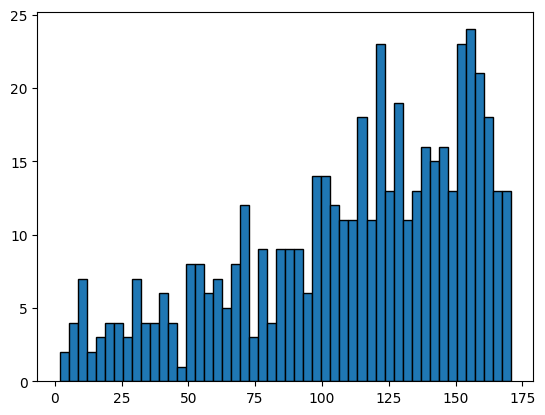

In [6]:
import matplotlib.pyplot as plt

# Plot the number of passengers boarded over time
times = [p.time_arrival for p in history]
plt.hist(times, bins=50, edgecolor='black')

In [7]:
average_waiting_times = []
for config in configurations:
    print(f'Configurazione: {config.num_navette} navette, Smart Driver: {config.smart_driver}, Smart Time: {config.smart_time}, Smart Percentage: {config.smart_percentage}')
    total_passengers = sum(len(history) for history in config.history)
    print(f'Totale passeggeri imbarcati: {total_passengers}')
    average_waiting_times.append(sum(p.time_departure - p.time_arrival for history in config.history for p in history if p.time_departure is not None) / total_passengers)
    print(f'Tempo medio di attesa per i passeggeri: {average_waiting_times[-1]:.2f} minuti')

Configurazione: 3 navette, Smart Driver: False, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di attesa per i passeggeri: 4.89 minuti


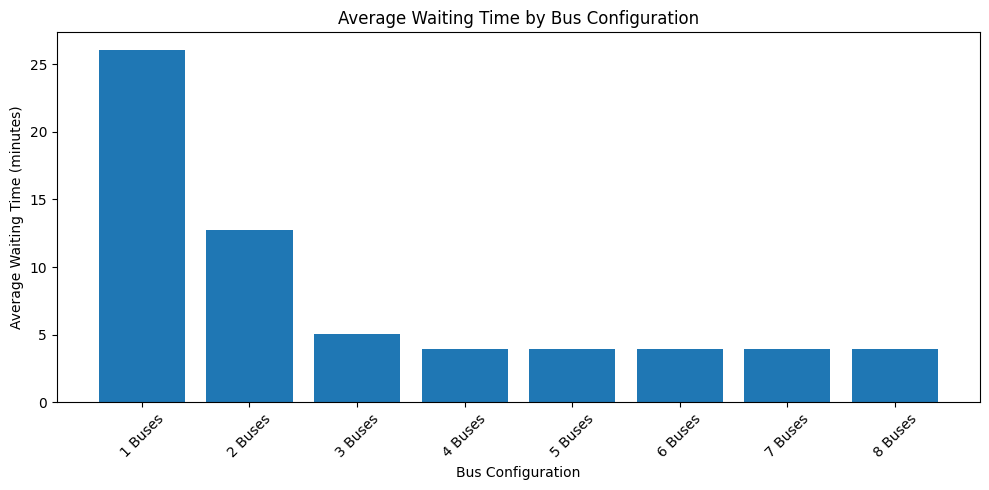

In [15]:
# Plot the average waiting times for each configuration
plt.figure(figsize=(10, 5))
plt.bar([f'{config.num_navette} Buses' for config in configurations], average_waiting_times)
plt.xlabel('Bus Configuration')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Average Waiting Time by Bus Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

(array([2.348e+03, 1.892e+03, 2.019e+03, 2.254e+03, 2.206e+03, 2.284e+03,
        2.292e+03, 2.015e+03, 1.543e+03, 1.290e+03, 9.960e+02, 7.260e+02,
        5.650e+02, 4.280e+02, 3.450e+02, 2.210e+02, 1.770e+02, 1.820e+02,
        1.370e+02, 1.300e+02, 1.410e+02, 1.170e+02, 9.600e+01, 9.100e+01,
        5.100e+01, 7.200e+01, 5.000e+01, 4.700e+01, 5.900e+01, 5.000e+01,
        3.100e+01, 1.900e+01, 1.900e+01, 2.500e+01, 1.400e+01, 9.000e+00,
        1.500e+01, 1.000e+01, 7.000e+00, 7.000e+00, 5.000e+00, 3.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 3.000e+00]),
 array([ 0.        ,  0.7290279 ,  1.4580558 ,  2.1870837 ,  2.9161116 ,
         3.6451395 ,  4.3741674 ,  5.1031953 ,  5.8322232 ,  6.5612511 ,
         7.290279  ,  8.0193069 ,  8.7483348 ,  9.4773627 , 10.2063906 ,
        10.9354185 , 11.6644464 , 12.3934743 , 13.1225022 , 13.8515301 ,
        14.580558  , 15.3095859 , 16.0386138 , 16.7676417 , 17.4966696 ,
        18.

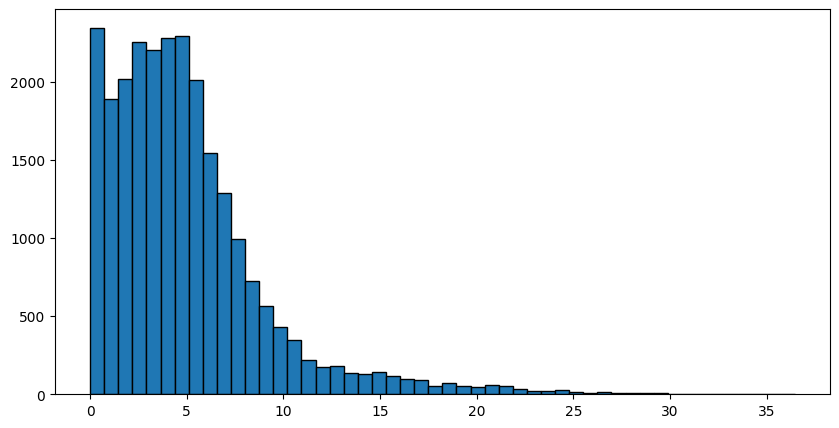

In [14]:
# plot distribution of waiting times for 3 buses configuration
plt.figure(figsize=(10, 5))
waiting_times = [p.time_departure - p.time_arrival for history in configurations[0].history for p in history if p.time_departure is not None]
plt.hist(waiting_times, bins=50, edgecolor='black')

In [15]:
# print maximum waiting time for each configuration and the arrival time of the maximum waiting time
print("\nMassimo tempo di attesa per ogni configurazione:")
for config in configurations:
    for history in config.history:
        curren_max = None
        for p in history:
            if p.time_departure is not None:
                waiting_time = p.time_departure - p.time_arrival
                if curren_max is None or waiting_time > curren_max[0]:
                    curren_max = (waiting_time, p.time_arrival, config.num_navette, config.smart_driver, config.smart_time, config.smart_percentage)
        print(f'maximum waiting time: {curren_max[0]:.2f} minutes, arrival time: {curren_max[1]:.2f} minutes, configuration: {curren_max[2]} buses, smart driver: {curren_max[3]}, smart time: {curren_max[4]}, smart percentage: {curren_max[5]}')



Massimo tempo di attesa per ogni configurazione:
maximum waiting time: 26.39 minutes, arrival time: 0.62 minutes, configuration: 3 buses, smart driver: False, smart time: 10, smart percentage: 0.5
maximum waiting time: 22.79 minutes, arrival time: 0.58 minutes, configuration: 3 buses, smart driver: False, smart time: 10, smart percentage: 0.5
maximum waiting time: 36.45 minutes, arrival time: 1.85 minutes, configuration: 3 buses, smart driver: False, smart time: 10, smart percentage: 0.5
maximum waiting time: 21.33 minutes, arrival time: 0.04 minutes, configuration: 3 buses, smart driver: False, smart time: 10, smart percentage: 0.5
maximum waiting time: 23.79 minutes, arrival time: 0.69 minutes, configuration: 3 buses, smart driver: False, smart time: 10, smart percentage: 0.5
maximum waiting time: 20.48 minutes, arrival time: 0.01 minutes, configuration: 3 buses, smart driver: False, smart time: 10, smart percentage: 0.5
maximum waiting time: 25.58 minutes, arrival time: 1.88 minute